# Train DECIPHER model

> (Estimated time: ~5 min with GPU)

In this vignette, we show how to train `DECIPHER` model on spatial omics data to obtain disentangled omics and spatial embedding. We have following steps:

1. Init model
2. Register data
3. Fit model
4. Visualize results



In [1]:
import scanpy as sc

from decipher import DECIPHER
from decipher.utils import scanpy_viz

In [5]:
sc.set_figure_params(dpi=80)

## Step 1: Init model
Init the model with a self-defined work_dir. It's better to have a directory that doesn't exist yet, `DECIPHER` will create it and save the model, log and embedding files in it.

In [16]:
# model = DECIPHER(work_dir='/path/to/work_dir')
model = DECIPHER(work_dir='./decipher')

2024-10-20 21:36:44.653 | SUCCESS  | decipher.utils:global_seed:347 - Global seed set to 0.


## Step 2: Register data

`DECIPHER` expect spatial omics data in`AnnData` object (or list of `AnnData`, see advanced topics) as input. The expression matrix should be raw counts (not log-normalized or scaled). And spatial coordinates should be saved in `adata.obsm['spatial']` slot.

> See `AnnData` [documentation](https://anndata.readthedocs.io/en/latest/index.html) for more details if you are unfamiliar, including how to construct `AnnData` objects from scratch, and how to read data in other formats (csv, mtx, loom, etc.) into `AnnData` objects.

Here we use a simulation dataset as an toy example, you can download it from [Google Drive](https://drive.google.com/file/d/10YpaS46z6GayE6WhtMUEq2OAa-u6C1fJ/view?usp=sharing).

In [3]:
# adata = sc.read_h5ad('/path/to/adata.h5ad')
adata = sc.read_h5ad('./adata.h5ad')
adata

AnnData object with n_obs × n_vars = 4512 × 31915
    obs: 'batch', 'leiden', 'cell_type', 'group', 'region'
    var: 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'gene_ids-0', 'gene_ids-1'
    uns: 'Reigon_colors', 'cell_type_colors', 'group_colors', 'region_colors', 'reigon_colors'
    obsm: 'spatial'

There are three cell types in the dataset
- T cell (CD3D+)
- B cell (CD79A+)
- Monocyte (CD14+)

We simulated three different spatial patterns:
- region 1: T cell & Monocyte mixed
- region 2: T cell only
- region 3: T cell & B cell mixed

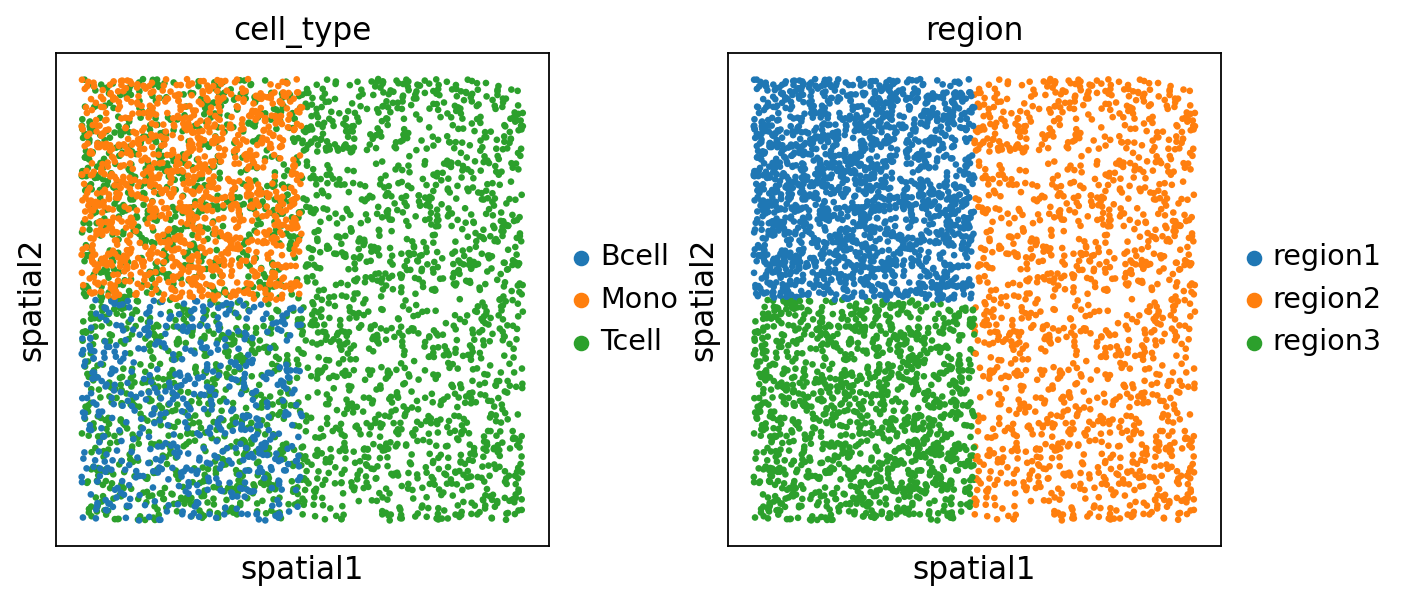

In [6]:
sc.pl.spatial(adata, color=['cell_type', 'region'], spot_size=0.03)

We need register the data to our model, it will automatically preprocess the data.

In [19]:
model.register_data(adata)

2024-10-20 21:36:45.712 | DEBUG    | decipher.data.process:omics_data_process:68 - adata 0 has 4512 cells, 31915 genes.
2024-10-20 21:36:45.715 | INFO     | decipher.data.process:omics_data_process:86 - Input: 1 slice(s) with 4512 cells and 1 batches.
2024-10-20 21:36:45.717 | INFO     | decipher.data.process:_preprocess_adata:98 - Preprocessing 4512 cells.
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
2024-10-20 21:36:48.639 | SUCCESS  | decipher.data.process:_preprocess_adata:148 - Preprocessing finished in 2.92 seconds.
2024-10-20 21:36:48.736 | SUCCESS  | decipher.graphic.build:build_graph:102 - Built knn graph with 4512 nodes and 90240 edges, 20.00 edges/node.


## Step 3: Fit model

Then we fit DECIPHER model:

In [20]:
model.fit_omics()

2024-10-20 21:36:48.787 | INFO     | decipher.emb:sc_emb:155 - Not found pre-trained model: list index out of range
2024-10-20 21:36:48.790 | INFO     | decipher.emb:_update_config:37 - Using 2000 genes as model input.
2024-10-20 21:36:48.792 | WARNING  | decipher.emb:_update_config:49 - Too few steps 51, try train more epochs.
2024-10-20 21:36:48.793 | DEBUG    | decipher.nn.models._basic:__init__:37 - {'model_dir': 'pretrain', 'fix_sc': False, 'spatial_emb': 'attn', 'transformer_layers': 3, 'num_heads': 1, 'dropout': 0.1, 'prj_dims': [128, 32, 32], 'temperature_center': 0.07, 'temperature_nbr': 0.07, 'lr_base': 0.01, 'lr_min': 0.001, 'weight_decay': 1e-05, 'first_cycle_steps': 51, 'warmup_steps': 5, 'epochs': 3, 'nbr_loss_weight': 0.5, 'plot': False, 'plot_hist': False, 'device': 'auto', 'select_gpu': True, 'device_num': 1, 'fp16': True, 'patient': 10, 'log_every_n_steps': 1, 'gradient_clip_val': 5.0, 'check_val_every_n_epoch': 1, 'max_steps': 51, 'augment': {'dropout_gex': 0.5, 'dro

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:36:50.760 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:50.763 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Metric train/total_loss improved. New best score: 1.866
Epoch 0, global step 17: 'train/total_loss' reached 1.86623 (best 1.86623), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/pretrain/epoch=0-step=17.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:36:51.771 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:51.774 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Metric train/total_loss improved by 0.661 >= min_delta = 0.0. New best score: 1.205
Epoch 1, global step 34: 'train/total_loss' reached 1.20537 (best 1.20537), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/pretrain/epoch=1-step=34.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:36:52.758 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:52.761 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Metric train/total_loss improved by 0.233 >= min_delta = 0.0. New best score: 0.972
Epoch 2, global step 51: 'train/total_loss' reached 0.97249 (best 0.97249), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/pretrain/epoch=2-step=51.ckpt' as top 3
`Trainer.fit` stopped: `max_steps=51` reached.
2024-10-20 21:36:53.014 | SUCCESS  | decipher.nn.trainer:fit:110 - Train finished in 3.89s.
2024-10-20 21:36:53.015 | INFO     | decipher.emb:_update_config:37 - Using 2000 genes as model input.
2024-10-20 21:36:53.016 | WARNING  | decipher.emb:_update_config:49 - Too few steps 102, try train more epochs.
/flash/grp/gglab/xiacr/DECIPHER-dev/conda/lib/python3.11/site-packages/torch_geometric/data/lightning/datamodule.py:43: The 'shuffle=True' optio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:36:56.043 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:56.048 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
2024-10-20 21:36:56.049 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:56.052 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Metric train/total_loss improved. New best score: 2.996
Epoch 0, global step 17: 'train/total_loss' reached 2.99638 (best 2.99638), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/model/epoch=0-step=17.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:36:57.856 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:57.860 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
2024-10-20 21:36:57.862 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:57.865 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Metric train/total_loss improved by 0.248 >= min_delta = 0.0. New best score: 2.748
Epoch 1, global step 34: 'train/total_loss' reached 2.74799 (best 2.74799), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/model/epoch=1-step=34.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:36:59.613 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:59.617 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
2024-10-20 21:36:59.618 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:36:59.635 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Epoch 2, global step 51: 'train/total_loss' reached 2.81808 (best 2.74799), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/model/epoch=2-step=51.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:37:01.187 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:37:01.191 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
2024-10-20 21:37:01.192 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:37:01.195 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Metric train/total_loss improved by 0.122 >= min_delta = 0.0. New best score: 2.626
Epoch 3, global step 68: 'train/total_loss' reached 2.62562 (best 2.62562), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/model/epoch=3-step=68.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:37:02.711 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:37:02.714 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
2024-10-20 21:37:02.716 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:37:02.718 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Epoch 4, global step 85: 'train/total_loss' reached 2.65988 (best 2.62562), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/model/epoch=4-step=85.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:37:04.255 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:37:04.259 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
2024-10-20 21:37:04.261 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:41 - Save embedding to disk
2024-10-20 21:37:04.263 | DEBUG    | decipher.nn.models._omics_mixin:save_embedding:56 - Save embedding to adata
Metric train/total_loss improved by 0.102 >= min_delta = 0.0. New best score: 2.524
Epoch 5, global step 102: 'train/total_loss' reached 2.52369 (best 2.52369), saving model to '/flash/grp/gglab/xiacr/DECIPHER-dev/docs/tutorials/decipher/model/epoch=5-step=102.ckpt' as top 3
`Trainer.fit` stopped: `max_steps=102` reached.
2024-10-20 21:37:05.772 | SUCCESS  | decipher.nn.trainer:fit:110 - Train finished in 12.65s.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Testing: |          | 0/? [00:00<?, ?it/s]

2024-10-20 21:37:06.697 | INFO     | decipher.cls:fit_omics:177 - Results saved to decipher


After training, we can extract disentangled omics and spatial embeddings from model:

In [21]:
gex_embedding = model.center_emb
nbr_embedding = model.nbr_emb

## Step 4: Visualize results

At last we cluster and visualize the embeddings.

In [22]:
adata.obsm['X_center'] = gex_embedding
adata.obsm['X_nbr'] = nbr_embedding
adata = scanpy_viz(adata, ['center', 'nbr'], rapids=False)

2024-10-20 21:37:06.910 | INFO     | decipher.utils:select_free_gpu:310 - Using GPU [2, 4] as computation device.


In [23]:
adata

AnnData object with n_obs × n_vars = 4512 × 2000
    obs: 'batch', 'leiden', 'cell_type', 'group', 'region', '_group', 'leiden_center', 'leiden_nbr'
    var: 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'gene_ids-0', 'gene_ids-1'
    uns: 'Reigon_colors', 'cell_type_colors', 'group_colors', 'region_colors', 'reigon_colors', 'hvg', 'log1p'
    obsm: 'spatial', 'X_center', 'X_nbr', 'X_umap_center', 'X_umap_nbr'

Firstly, we check the omics embedding, we found it matches the cell type ground truth well.

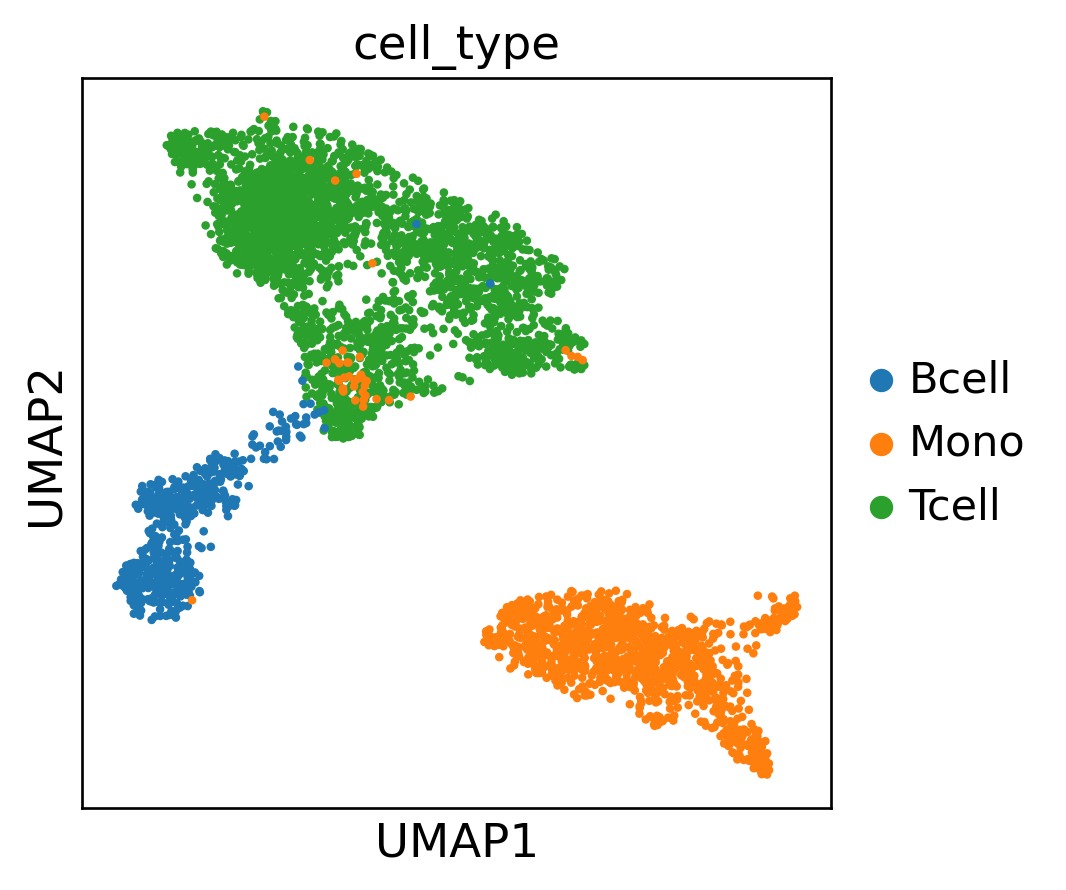

In [24]:
adata.obsm['X_umap'] = adata.obsm['X_umap_center'].copy()
sc.pl.umap(adata, color=['cell_type'])

Then we check the spatial embedding, we found it matches the spatial patterns ground truth well.


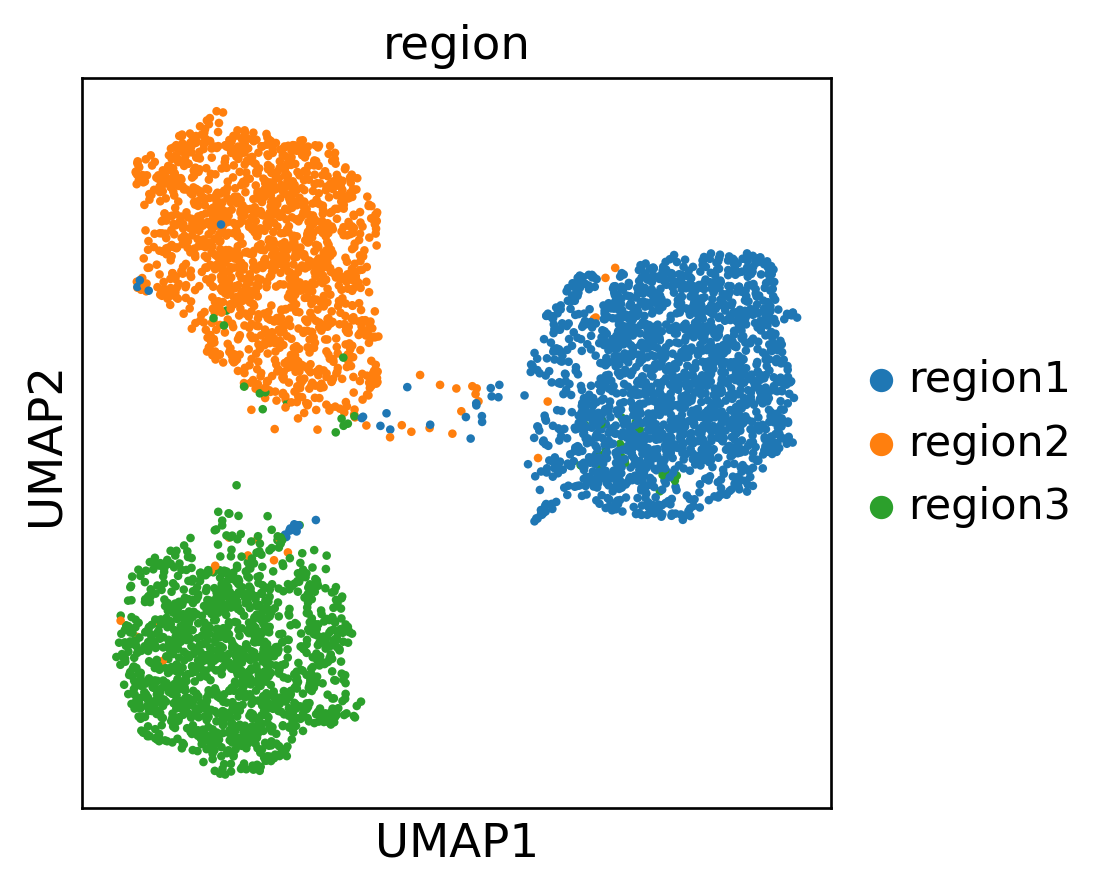

In [25]:
adata.obsm['X_umap'] = adata.obsm['X_umap_nbr'].copy()
sc.pl.umap(adata, color=['region'])